# 打开股票量化的黑箱(自己动手实现一个印钞机) 第八章
### 作者：阿布🐶

### 未经本人允许禁止转载

##  非均衡胜负收益带来的必然非均衡胜负比例，目标由因子的能力解决一部分，模式识别提升关键的一部分

In [1]:
import ZEnv
import ZLog
import ZCommonUtil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 100
%matplotlib inline

上一章构建完所有的裁判，并且通过可视化选择了裁判的参数，通过数据统计构建了拦截规则, 拦截规则通过
UmpPipeLineClass融合在一起形成拦截规则，这里不做过多代码讲解，最后一章了，轻松点吧，有兴趣可以查看源代码UmpPipeLine.py

这一章的工作，使用11年后至今学习的数据作用在10年的回测与没有作用的进行对比

* run_factor_by_year生成10年的回测结果集
* run_func：回测不开启识别优化
* run_func_with_filter：回测开启识别优化
* run_func_with_ml：回测开启识别但只做数据记录构成统计数据不做交易拦截

In [2]:
import FactorUnitTest
import BuyGoldenFactor
import SymbolPd
from BuyGoldenFactor import BuyGoldenFactorClass

def run_factor_by_year(enable_fiter, enable_filter_ml, enable_snap, enable_filter_pipe_ml, symbols=None):
    SymbolPd.g_force_folds = 7
    SymbolPd.g_force_n_year = 1
    
    BuyGoldenFactor.g_enable_fiter = enable_fiter
    
    BuyGoldenFactor.g_enable_filter_ml = enable_filter_ml
    BuyGoldenFactor.g_enable_snap = enable_snap
    BuyGoldenFactor.g_enable_filter_pipe_ml = enable_filter_pipe_ml
    
    buy_factors = [{'XD': 42, 'class': BuyGoldenFactorClass, 'draw': True}]
    sell_factors = []
    parameters = {
        'stop_win_base_n': 4.5,
        'stop_loss_base_n': 2.0,
        'mv_close_atr': 3.5,
        'mv_pre_atr': 2.0,
    }
    if symbols is None:
        cap, results, orders_pd, action_pd, all_fit_symbols = FactorUnitTest.random_unit_test(ret_cnt_need=0, 
                buy_factors=buy_factors, sell_factors=sell_factors, parameters=parameters, show=False)
    else:
        cap, results, orders_pd, action_pd, all_fit_symbols = FactorUnitTest.random_unit_test(ret_cnt_need=0, 
                symbols=symbols,
                buy_factors=buy_factors, sell_factors=sell_factors, parameters=parameters, show=False)
    return cap, results, orders_pd, action_pd, all_fit_symbols

from functools import partial
run_func = partial(run_factor_by_year, False, False, False, False)
run_func_with_filter = partial(run_factor_by_year, True, False, False, False)
run_func_with_ml = partial(run_factor_by_year, True, False, False, True)
run_func_with_snap = partial(run_factor_by_year, True, False, True, False)

首先对2010年使用因子进行回测，纯回测，不记录学习统计数据，不对交易进行纠正拦截

all fit order = (8077, 31)
win rate = 0.507366596509
profit_cg.sum() = 63.1474660094
win mean = 0.0710351737508 loss_mean = -0.0575207358116 


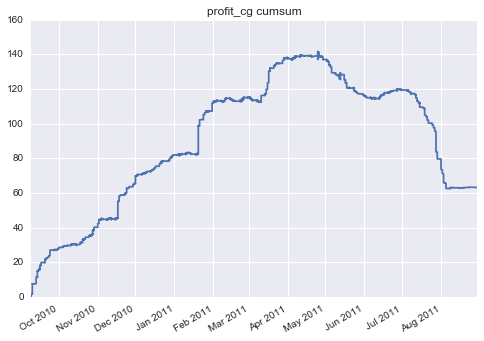

In [19]:
import MetricsManger
from MetricsManger import metrics_rsc
from FactorMetrics import METRICSTYPE
from UmpMain import UmpMainClass
from MlFiterGoldenPd import MlFiterGoldenPdClass
rsc_ret = run_func()
rsc = metrics_rsc(*rsc_ret)
MetricsManger.make_metrics_from_rsc(rsc, METRICSTYPE.SYSMBOL_R_SCORES_GOLDEN.value, show=False)
UmpMainClass(rsc.ordersPd, MlFiterGoldenPdClass).show_general()

然后对2010年使用因子进行回测并且进行纠正拦截

all fit order = (7732, 31)
win rate = 0.518734609415
profit_cg.sum() = 66.8634043939
win mean = 0.0695253920443 loss_mean = -0.0553854481924 


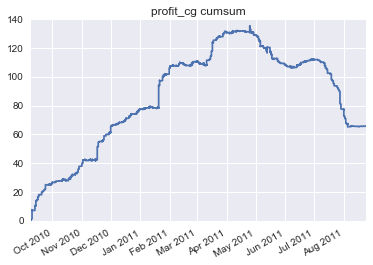

In [4]:
rsc_filter_ret = run_func_with_filter()
rsc_filter = metrics_rsc(*rsc_filter_ret)
MetricsManger.make_metrics_from_rsc(rsc_filter, METRICSTYPE.SYSMBOL_R_SCORES_GOLDEN.value, show=False)
UmpMainClass(rsc_filter.ordersPd, MlFiterGoldenPdClass).show_general()

In [27]:
rsc.ordersPd.shape[0] - rsc_filter.ordersPd.shape[0]

403

已经有结果的统计数据

In [21]:
8077 - 7732, 0.518734609415 - 0.507366596509, 66.8634043939 - 63.1474660094

(345, 0.011368012906000091, 3.7159383844999994)

## 对结果满意吗？对345笔交易进行拦截，胜率提升了0.011，还不错嘛，但是你知道实际结果可能会更好吗，你发现2010年最后的这几个月是下行阶段吗？你发现一共拦截了403个单子吗，但有结果的只有345个单子，也就是这里的结果统计是针对已经有结果的单子进行统计，很有可能拦截的规则在最后这一段集中爆发，但是由于没有进行拦截的那些统计数据里由于最后仍为成交，并没有计算到胜率里，好，我们下面就将证明这个猜想是否正确

run_func_with_ml针对交易学习数据分类结果

In [ ]:
rsc_ml_ret = run_func_with_ml()
rsc_ml = metrics_rsc(*rsc_ml_ret)
MetricsManger.make_metrics_from_rsc(rsc_ml, METRICSTYPE.SYSMBOL_R_SCORES_GOLDEN.value, show=False)
order_pd_ml = rsc_ml.ordersPd

这样只对交易只进行数据写入，不进行最终的拦截，因而数据只包含了如下

In [9]:
can_win_pd = order_pd_ml.filter(['result', 'can_win', 'edge', 'edge_type'])
can_win_pd.head()

,result,can_win,edge,edge_type
2010-11-09,0,1,1,8
2011-03-30,0,1,0,8
2011-07-12,0,0,-1,0
2011-07-15,0,1,0,8
2011-07-28,0,1,0,8


对照UmpPipeLineClass中learn_pipe_line_predict的返回结果，从crosstab上看整个结果是 理想的，问题应该出在edge_type ＝ 0的有35个还持有的单子type 0的分类是主裁hit了20次以上的交易，可以说是最有保证应该被拦截的

In [10]:
pd.crosstab([can_win_pd['result'], can_win_pd['can_win']], can_win_pd['edge_type'])

edge_type        0  1  4  6    7     8
result can_win                        
-1     0        21  6  1  2  166     0
       1         0  0  0  0    0  3783
 0     0        35  1  0  3   19     0
       1         0  0  0  0    0   235
 1     0        11  3  0  0  135     0
       1         0  0  0  0    0  3949

In [20]:
 # 这里还是贴代码了，本想最后一章轻松一点😭，只为阐述上面的表格对拦截进行分类的代码0-8类别
 class UmpPipeLineClass(object):
    def __init__(self, ump_dict):
        self.ump_dict = ump_dict

        self.main_umps = []
        self.jump_ump = None
        self.edge_ump = None
        for ump, ump_args in self.ump_dict.items():
            if isinstance(ump, UmpMainClass):
                self.main_umps.append((ump, ump_args))
            elif isinstance(ump, UmpJumpClass):
                self.jump_ump = (ump, ump_args)
            elif isinstance(ump, UmpEdgeClass):
                self.edge_ump = (ump, ump_args)
            else:
                raise TypeError('what a ump type set!')

    def do_pipe_line_predict(self, **kwargs):
        return self.learn_pipe_line_predict(**kwargs)[0]

    def learn_pipe_line_predict(self, **kwargs):
        """
        :param kwargs:
        :return:
        """
        main_hit_cnt = 0
        for ump, ump_args in self.main_umps:
            if 'cons' in ump_args:
                cons_func = ump_args['cons']
                if not cons_func(kwargs):
                    """
                        执行限制条件func, exp
                        UmpJumpClass(None, MlFiterJumpPdClass, predict=True): {'w_col': MlFiterJumpPd.g_w_col,
                        'need_ind_cnt': 1, 'cons': lambda order: order['diff_days'] < 21}
                    """
                    continue
            if 'w_col' not in ump_args:
                raise ValueError('MISS w_col not in ump_args!!!')
            main_hit_cnt += ump.predict_hit_kwargs(ump_args['w_col'], **kwargs)

        jump_hit_cnt = 0
        if self.jump_ump is not None:
            ump, ump_args = self.jump_ump
            if 'cons' in ump_args:
                cons_func = ump_args['cons']
                if cons_func(kwargs) and 'w_col' in ump_args:
                    jump_hit_cnt = ump.predict_hit_kwargs(ump_args['w_col'], **kwargs)

        if self.edge_ump is not None:
            ump, ump_args = self.edge_ump
            edge_pred = ump.predict(**kwargs)

            """
                所有参数通过learn_ump_hit_cnt，learn_ump_predict
                学习可视化而来，微调不要对数据过拟合, if逻辑有重复可优化
                但为外面ml提供细的类别暂时不要优化
            """
            if main_hit_cnt >= 20 and edge_pred <> 1:
                return 0, edge_pred, 0

            if jump_hit_cnt >= 5 and edge_pred <> 1:
                return 0, edge_pred, 1

            if jump_hit_cnt > 1 and main_hit_cnt > 10:
                return 0, edge_pred, 2

            if edge_pred == 1 and (jump_hit_cnt >= 3 and main_hit_cnt >= 6):
                return 0, edge_pred, 3

            if edge_pred == 1 and main_hit_cnt >= 25:
                return 0, edge_pred, 4

            if edge_pred == 0 and (jump_hit_cnt >= 2 and main_hit_cnt >= 4):
                return 0, edge_pred, 5

            if edge_pred == 0 and main_hit_cnt >= 15:
                return 0, edge_pred, 6

            if edge_pred == -1 and (main_hit_cnt >= 1 or jump_hit_cnt >= 1):
                return 0, edge_pred, 7

            return 1, edge_pred, 8
        return 1, -1, -1

以周期内最后一天为限制日，查看这35个单子的盈亏情况，结果喜人阿！

In [16]:
from Capital import CapitalClass
import SymbolPd
orders_pd_n_ret = order_pd_ml[(order_pd_ml.result == 0) & (order_pd_ml.edge_type == 0)]
cap = CapitalClass(1000000000)
def calc_last_loss(order):
    kl_pd = SymbolPd.make_kfold_pd(order.Symbol, cap=cap)
    return kl_pd.iloc[-1].close - order['buy Price']

last_loss_result = orders_pd_n_ret.apply(calc_last_loss, axis=1)
last_loss_result.sum()
dummies_result = pd.Series(np.where(last_loss_result > 0, 1, 0))
float(dummies_result.value_counts()[0])/dummies_result.value_counts().sum()

0.6571428571428571

In [19]:
dummies_result.value_counts()[0], dummies_result.value_counts()[1]

(23, 12)

结果显示最后这批交易只有35%是盈利的，这样看来最终的胜率还能有所提升的

这篇文章到这里就算是个完结了，这篇文章的中心再次重申

##  非均衡胜负收益带来的必然非均衡胜负比例，目标由因子的能力解决一部分，模式识别提升关键的一部分

### 也许你看到最后发现一共胜率只提高1个多点，怎么模式识别就成为关键环节了，因为针对因子的能力很大一部分是需要依靠大盘的走势的（在不考虑做空的前提下），然而模式识别这部分能力不论大盘好坏它都要发挥功用，就像这里最后介绍的这个实例，大盘不好的时候模式识别拦截了更多的交易，更何况你可以通过各种手段去优化这部分能力，比如我的系统中的裁判机制，这里这个只是为了演示方便，实际上的裁决系统也许主裁就有数十个，辅助裁判也会有很多，它们会利用更合理的组合方案组成 pipeline来提升效果，但是印钞机还有很多复杂的组件，回测系统，交易系统，风险控制系统，因子优化系统，还有实盘系统, 每一个环节不准许有一点差池，在你的意识里要接近完美的去写每一行代码，去检测每一行代码，就算这样，也许有一天你仍然会发现某个环节有个bug一直没有发现，导致你对整个系统的信心下降，但你不能放弃，因为这是你自己选择的道路，跪着也走完它吧！

## 最后送上海龟交易法则中我最喜欢的那句话

## 林中有两条路，我选择了人迹更少的那一条，一切皆源于此 　　 ----罗伯特·弗罗斯特 


## 感谢🙏您能有耐心看到这里
## 如果有什么问题可以加阿布的微信 
## 微信号：aaaabbbuu

![image](./mmexport1475383814280.jpg)